In [1]:
import polars as pl
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

data_dir = Path("../data")

full = pl.scan_parquet(data_dir / "joined_data_train_3.parquet")

In [3]:
df_labeled = (
  full
  .filter(pl.col("label") != "UNKNOWN")
  .select("transaction_id", "category", "label")
  .with_columns(pl.col("category").fill_null("missing"))
)

df_normal = df_labeled.filter(pl.col("label") == "NORMAL")
df_fraud = df_labeled.filter(pl.col("label") == "FRAUD")

In [4]:
def generate_category_list(df: pl.LazyFrame) -> pl.LazyFrame:
    """
    Generate a list of unique categories for each transaction_id.
    """
    categories_by_transaction = (
        df.group_by("transaction_id")
        .agg([
            pl.col("category").alias("category_list")
        ])
        .select("transaction_id", "category_list")
    )
    return categories_by_transaction.collect().select("category_list").to_series().to_list()

In [5]:
import pandas as pd
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori

def calculate_frequent_itemsets(transactions, min_support=0.6):
    """
    Calculate frequent itemsets using the Apriori algorithm.
    """
    te = TransactionEncoder()
    te_ary = te.fit(transactions).transform(transactions)
    df = pd.DataFrame(te_ary, columns=te.columns_)
    frequent_itemsets = apriori(df, min_support=min_support, use_colnames=True)
    frequent_itemsets = frequent_itemsets.sort_values(by="support", ascending=False)
    return frequent_itemsets

In [6]:
transactions = generate_category_list(df_normal)
frequent_itemsets_normal = calculate_frequent_itemsets(transactions, min_support=0.1)

In [7]:
transactions = generate_category_list(df_fraud)
frequent_itemsets_fraud = calculate_frequent_itemsets(transactions, min_support=0.1)

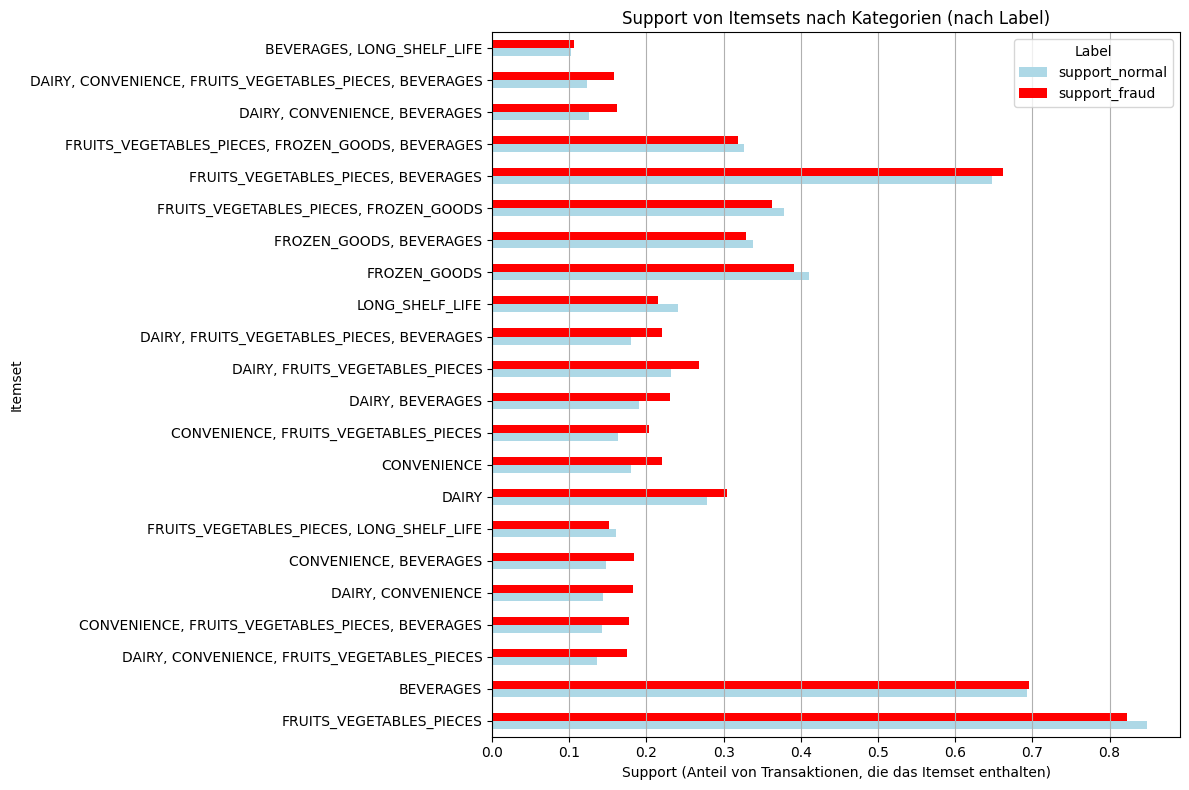

In [8]:
# join the two pandas dataframes
frequent_itemsets = frequent_itemsets_normal.merge(
    frequent_itemsets_fraud,
    on="itemsets",
    suffixes=("_normal", "_fraud"),
    how="outer"
)
# order the columns
frequent_itemsets = frequent_itemsets[["itemsets", "support_normal", "support_fraud"]]
frequent_itemsets = frequent_itemsets.fillna(0)

# plot the results as a bar plot with seaborn
# itemsests as y-axis
frequent_itemsets.plot(kind='barh', figsize=(12, 8), color=['lightblue', 'red'])
plt.title(f'Support von Itemsets nach Kategorien (nach Label)')
plt.xlabel("Support (Anteil von Transaktionen, die das Itemset enthalten)")
plt.ylabel('Itemset')
plt.legend(title='Label')
plt.grid(axis='x')
# plot the value in itemesets on the y-axis insted of the index
plt.yticks(range(len(frequent_itemsets)), frequent_itemsets['itemsets'].apply(lambda x: ', '.join(x)))
plt.tight_layout()
plt.show()